In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
from UNetWithResNet34Encoder import UnetResnet34
from SegmentationDataset import SegmentationDataset

Constants

In [7]:
color2id = {
    (0, 0, 0): 0,          # Unlabeled
    (111, 74, 0): 1,       # Dynamic
    (81, 0, 81): 2,        # Ground
    (128, 64, 128): 3,     # Road
    (244, 35, 232): 4,     # Sidewalk
    (250, 170, 160): 5,    # Parking
    (230, 150, 140): 6,   # Rail track
    (70, 70, 70): 7,      # Building
    (102, 102, 156): 8,   # Wall
    (190, 153, 153): 9,   # Fence
    (180, 165, 180): 10,   # Guard rail
    (150, 100, 100): 11,   # Bridge
    (150, 120, 90): 12,    # Tunnel
    (153, 153, 153): 13,   # Pole
    (153, 153, 153): 14,   # Pole group
    (250, 170, 30): 15,    # Traffic light
    (220, 220, 0): 16,     # Traffic sign
    (107, 142, 35): 17,    # Vegetation
    (152, 251, 152): 18,   # Terrain
    (70, 130, 180): 19,    # Sky
    (220, 20, 60): 20,     # Person
    (255, 0, 0): 21,       # Rider
    (0, 0, 142): 22,       # Car
    (0, 0, 70): 23,        # Truck
    (0, 60, 100): 24,      # Bus
    (0, 0, 90): 25,        # Caravan
    (0, 0, 110): 26,       # Trailer
    (0, 80, 100): 27,      # Train
    (0, 0, 230): 28,       # Motorcycle
    (119, 11, 32): 29      # Bicycle
}

id2color = {
    0: (0, 0, 0),          # Unlabeled
    1: (111, 74, 0),       # Dynamic
    2: (81, 0, 81),        # Ground
    3: (128, 64, 128),     # Road
    4: (244, 35, 232),     # Sidewalk
    5: (250, 170, 160),    # Parking
    6: (230, 150, 140),    # Rail track
    7: (70, 70, 70),       # Building
    8: (102, 102, 156),    # Wall
    9: (190, 153, 153),    # Fence
    10: (180, 165, 180),   # Guard rail
    11: (150, 100, 100),   # Bridge
    12: (150, 120, 90),    # Tunnel
    13: (153, 153, 153),   # Pole
    14: (153, 153, 153),   # Pole group
    15: (250, 170, 30),    # Traffic light
    16: (220, 220, 0),     # Traffic sign
    17: (107, 142, 35),    # Vegetation
    18: (152, 251, 152),   # Terrain
    19: (70, 130, 180),    # Sky
    20: (220, 20, 60),     # Person
    21: (255, 0, 0),       # Rider
    22: (0, 0, 142),       # Car
    23: (0, 0, 70),        # Truck
    24: (0, 60, 100),      # Bus
    25: (0, 0, 90),        # Caravan
    26: (0, 0, 110),       # Trailer
    27: (0, 80, 100),      # Train
    28: (0, 0, 230),       # Motorcycle
    29: (119, 11, 32)      # Bicycle
}

path = "/net/ens/am4ip/datasets/project-dataset"
rainyImagesPath = path + '/rainy_images'
rainySsegPath = path + '/rainy_sseg'
sunnyImagesPath = path + '/sunny_images'
sunnySsegPath = path + '/sunny_sseg'

rainyDenoised = "/net/cremi/mhajnal/espaces/travail/am4ipProject/rainyDenoised"
sunnyDenoised = "/net/cremi/mhajnal/espaces/travail/am4ipProject/sunnyDenoised"

Dataset

In [3]:
def getImageMaskPairs(imagesDir, ssegDir):
    imageFiles = [f for f in os.listdir(imagesDir) if f.endswith(('.png', '.jpg'))]
    imageFiles.sort()

    imagePaths = []
    maskPaths = []
    for img in imageFiles:
        maskName = os.path.splitext(img)[0] + '.png'
        maskPath = os.path.join(ssegDir, maskName)
        if os.path.exists(maskPath):
            imagePaths.append(os.path.join(imagesDir, img))
            maskPaths.append(maskPath)
        else:
            print(f"Warning: Mask not found for image {img}")
    return imagePaths, maskPaths

Just for sunny:

In [4]:
sunnyImages, sunnyMasks = getImageMaskPairs(sunnyImagesPath, sunnySsegPath)

selectedSunnyImages = random.sample(sunnyImages, 500)
selectedSunnyMasks = [sunnyMasks[sunnyImages.index(img)] for img in selectedSunnyImages]

train_img, temp_img, train_mask, temp_mask = train_test_split(selectedSunnyImages, selectedSunnyMasks, test_size=0.3)
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5)

Just for rainy:

In [4]:
rainyImages, rainyMasks = getImageMaskPairs(rainyImagesPath, rainySsegPath)

selectedRainyImages = random.sample(rainyImages, 500)
selectedRainyMasks = [rainyMasks[rainyImages.index(img)] for img in selectedRainyImages]

train_img, temp_img, train_mask, temp_mask = train_test_split(selectedRainyImages, selectedRainyMasks, test_size=0.3)
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5)

Mixed:

In [ ]:
sunnyImages, sunnyMasks = getImageMaskPairs(sunnyImagesPath, sunnySsegPath)
rainyImages, rainyMasks = getImageMaskPairs(rainyImagesPath, rainySsegPath)

selectedSunnyImages = random.sample(sunnyImages, 100)
selectedSunnyMasks = [sunnyMasks[sunnyImages.index(img)] for img in selectedSunnyImages]

selectedRainyImages = random.sample(rainyImages, 100)
selectedRainyMasks = [rainyMasks[rainyImages.index(img)] for img in selectedRainyImages]

mixedImages = selectedSunnyImages + selectedRainyImages
mixedMasks = selectedSunnyMasks + selectedRainyMasks

train_img, temp_img, train_mask, temp_mask = train_test_split(mixedImages, mixedMasks, test_size=0.3)
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5)

Rainy denoised

In [4]:
rainyImages, rainyMasks = getImageMaskPairs(rainyDenoised, rainySsegPath)

selectedRainyImages = random.sample(rainyImages, 500)
selectedRainyMasks = [rainyMasks[rainyImages.index(img)] for img in selectedRainyImages]

train_img, temp_img, train_mask, temp_mask = train_test_split(selectedRainyImages, selectedRainyMasks, test_size=0.3)
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5)

Sunny denoised

In [23]:
sunnyImages, sunnyMasks = getImageMaskPairs(sunnyDenoised, sunnySsegPath)

selectedSunnyImages = random.sample(sunnyImages, 500)
selectedSunnyMasks = [sunnyMasks[sunnyImages.index(img)] for img in selectedSunnyImages]

train_img, temp_img, train_mask, temp_mask = train_test_split(selectedSunnyImages, selectedSunnyMasks, test_size=0.3)
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5)

Mixed: Sunny + Rainy Denoised

In [4]:
sunnyImages, sunnyMasks = getImageMaskPairs(sunnyImagesPath, sunnySsegPath)
rainyImages, rainyMasks = getImageMaskPairs(rainyDenoised, rainySsegPath)


selectedSunnyImages = random.sample(sunnyImages, 2000)
selectedSunnyMasks = [sunnyMasks[sunnyImages.index(img)] for img in selectedSunnyImages]

selectedRainyImages = random.sample(rainyImages, 2000)
selectedRainyMasks = [rainyMasks[rainyImages.index(img)] for img in selectedRainyImages]

mixedImages = selectedSunnyImages + selectedRainyImages
mixedMasks = selectedSunnyMasks + selectedRainyMasks

train_img, temp_img, train_mask, temp_mask = train_test_split(mixedImages, mixedMasks, test_size=0.3)
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5)

Transforms

In [6]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Only for input images
    transforms.ColorJitter(brightness=[0.5,0.8], contrast=0, saturation=0, hue=0),
    transforms.GaussianBlur(kernel_size=5)
])

# Separate transform for masks (no normalization)
mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [25]:
train_dataset = SegmentationDataset(train_img, train_mask, transform=transform, mask_transform=mask_transform)
val_dataset = SegmentationDataset(val_img, val_mask, transform=transform, mask_transform=mask_transform)
test_dataset = SegmentationDataset(test_img, test_mask, transform=transform, mask_transform=mask_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

Setting up training parameters

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UnetResnet34().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/autofs/unityaccount/ens/DeepLearning/python3/tensorflow2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/autofs/unityaccount/ens/DeepLearning/python3/tensorflow2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Main train function and metrics

In [10]:
import segmentation_models_pytorch as smp
def calcIoU(pred_class, masks, num_classes):
    tp, fp, fn, tn = smp.metrics.get_stats(
                output=pred_class.detach().cpu().long(),
                target=masks.cpu(),
                mode="multiclass",
                ignore_index=-1,
                num_classes=num_classes
            )
    batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    return batch_iou

def calcMeanIoU(pred_class, masks, num_classes):
    tp, fp, fn, tn = smp.metrics.get_stats(
            output=pred_class.detach().cpu().long(),
            target=masks.cpu(),
            mode="multiclass",
            num_classes=num_classes
        )
        
    # Sum the statistics across all samples in the batch for each class
    tp_sum = tp.sum(dim=0)  # Sum across batch dimension
    fp_sum = fp.sum(dim=0)  # Sum across batch dimension
    fn_sum = fn.sum(dim=0)  # Sum across batch dimension
    
    # Calculate IoU for each class
    class_ious = []
    for class_idx in range(num_classes):
        class_tp = tp_sum[class_idx]
        class_fp = fp_sum[class_idx]
        class_fn = fn_sum[class_idx]
        
        # Check if the class appears in the ground truth or prediction
        denominator = (class_tp + class_fp + class_fn).item()
        if denominator == 0:
            continue
            
        class_iou = (class_tp / (class_tp + class_fp + class_fn + 1e-7)).item()
        class_ious.append(class_iou)
    
    # Return mean over all classes that appear in the image
    return np.mean(class_ious) if class_ious else 0.0

def calcMeanPA(pred, target, num_classes):
    accuracies = []
    for cls in range(num_classes):
        cls_mask = (target == cls)
        if cls_mask.sum() == 0:
            continue
        cls_accuracy = ((pred == cls) & cls_mask).sum().float() / cls_mask.sum()
        accuracies.append(cls_accuracy)
    return torch.stack(accuracies).mean() if accuracies else torch.tensor(0.0).to(pred.device)


In [11]:
import torch
import time
import os
from tqdm import tqdm
import segmentation_models_pytorch as smp

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, 
                checkpoint_dir='checkpoints', checkpoint_freq=10, resume=False, num_classes=30, patience=10, min_delta=1e-4, runName='defaultRun'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0
    best_val_loss = float('inf')
    results = {'train_loss': [], 'train_iou': [], 'train_miou': [], 'train_mPA':[], 'val_loss': [], 'val_iou': [], 'val_miou': [], 'val_mPA': [], 'epoch_times': []}
    counter = 0
    early_stop = False

    # If we want to resume training
    if resume:
        latest_checkpoint = max([f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_')], key=lambda x: int(x.split('_')[1].split('.')[0])) if os.listdir(checkpoint_dir) else None
        if latest_checkpoint:
            checkpoint = torch.load(os.path.join(checkpoint_dir, latest_checkpoint))
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            results = checkpoint['results']
            best_val_loss = checkpoint['best_val_loss']
            print(f'Resuming from epoch {start_epoch}')

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        if early_stop:
            break       # Break out of the training loop if early stop is triggered

        epoch_start = time.time()
        model.train()
        train_loss = 0
        train_iou = 0
        train_miou = 0
        train_mPA = 0
        
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        
        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            pred_prob = outputs.softmax(dim=1)
            pred_class = pred_prob.argmax(dim=1)
            
            # Calculate metrics
            batch_iou = calcIoU(pred_class, masks, num_classes)
            batch_miou = calcMeanIoU(pred_class, masks, num_classes)
            batch_mPA = calcMeanPA(pred_class, masks, num_classes)


            
            train_loss += loss.item()
            train_iou += batch_iou
            train_miou += batch_miou
            train_mPA += batch_mPA
            
            train_loader_tqdm.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'IoU': f'{batch_iou:.4f}',
                'mIoU': f'{batch_miou:.4f}',
                'mPA': f'{batch_mPA:.4f}'
            })
        
        # Validation loop
        model.eval()
        val_loss = 0
        val_iou = 0
        val_miou = 0
        val_mPA = 0
        
        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc='Validation')
            for images, masks in val_loader_tqdm:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                pred_prob = outputs.softmax(dim=1)
                pred_class = pred_prob.argmax(dim=1)
                
                
                batch_iou = calcIoU(pred_class, masks, num_classes)
                batch_miou = calcMeanIoU(pred_class, masks, num_classes)
                batch_mPA = calcMeanPA(pred_class, masks, num_classes)

                val_loss += loss.item()
                val_iou += batch_iou
                val_miou += batch_miou
                val_mPA += batch_mPA


                val_loader_tqdm.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'IoU': f'{batch_iou:.4f}',
                    'mIoU': f'{batch_miou:.4f}',
                    'mPA': f'{batch_mPA:.4f}'
                })
        
        # Save results for plotting
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_miou = train_miou / len(train_loader)
        avg_train_mPA = train_mPA / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_miou = val_miou / len(val_loader)
        avg_val_mPA = val_mPA / len(val_loader)
        epoch_time = time.time() - epoch_start
        
        results['train_loss'].append(avg_train_loss)
        results['train_iou'].append(avg_train_iou)
        results['train_miou'].append(avg_train_miou)
        results['train_mPA'].append(avg_train_mPA)
        results['val_loss'].append(avg_val_loss)
        results['val_iou'].append(avg_val_iou)
        results['val_miou'].append(avg_val_miou)
        results['val_mPA'].append(avg_val_mPA)
        results['epoch_times'].append(epoch_time)
        
        print(f"Epoch: {epoch + 1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train IoU: {avg_train_iou:.4f} | "
              f"Train mIoU: {avg_train_miou:.4f} | "
              f"Train mPA: {avg_train_mPA:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val IoU: {avg_val_iou:.4f} | "
              f"Val mIoU: {avg_val_miou:.4f} | "
              f"Val mPA: {avg_val_mPA:.4f} | "
              f"Time: {epoch_time:.2f}s")
        
        # Save best model
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            counter = 0
            # Save best model
            best_model_path = os.path.join(checkpoint_dir, runName+'.pth')
            print(f'Saving best model (val_loss: {best_val_loss:.4f})')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'train_iou': avg_train_iou,
                'train_miou': avg_train_miou,
                'train_mPA': avg_train_mPA,
                'val_loss': avg_val_loss,
                'val_iou': avg_val_iou,
                'val_miou': avg_val_miou,
                'val_mPA': avg_val_mPA
            }, best_model_path)
        else:
            counter += 1
            if counter >= patience:
                early_stop = True
                print(f'Early stopping triggered after {epoch + 1} epochs!')


        # Save checkpoint
        if epoch % checkpoint_freq == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results': results,
                'best_val_loss': best_val_loss
            }, checkpoint_path)
    
    return results

Training!

In [12]:
runName = 'NEW_sunny_500mix_AugmentLikeRain_ResNet34'
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device=device, runName=runName)

Validation: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s, Loss=2.2877, IoU=0.6767, mIoU=0.1442, mPA=0.1850]


Epoch: 1/50 | Train Loss: 2.9449 | Train IoU: 0.4499 | Train mIoU: 0.0725 | Train mPA: 0.1235 | Val Loss: 2.2893 | Val IoU: 0.6449 | Val mIoU: 0.1305 | Val mPA: 0.1665 | Time: 56.18s
Saving best model (val_loss: 2.2893)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=1.0125, IoU=0.6798, mIoU=0.1461, mPA=0.1850]


Epoch: 2/50 | Train Loss: 1.6274 | Train IoU: 0.6810 | Train mIoU: 0.1276 | Train mPA: 0.1568 | Val Loss: 1.1212 | Val IoU: 0.6509 | Val mIoU: 0.1329 | Val mPA: 0.1673 | Time: 49.90s
Saving best model (val_loss: 1.1212)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.7331, IoU=0.6853, mIoU=0.1482, mPA=0.1864]


Epoch: 3/50 | Train Loss: 0.8438 | Train IoU: 0.6848 | Train mIoU: 0.1281 | Train mPA: 0.1554 | Val Loss: 0.8318 | Val IoU: 0.6533 | Val mIoU: 0.1345 | Val mPA: 0.1677 | Time: 50.09s
Saving best model (val_loss: 0.8318)


Validation: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s, Loss=0.6165, IoU=0.6935, mIoU=0.1579, mPA=0.1989]


Epoch: 4/50 | Train Loss: 0.6559 | Train IoU: 0.6886 | Train mIoU: 0.1299 | Train mPA: 0.1572 | Val Loss: 0.7110 | Val IoU: 0.6643 | Val mIoU: 0.1443 | Val mPA: 0.1794 | Time: 50.22s
Saving best model (val_loss: 0.7110)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.5489, IoU=0.7115, mIoU=0.1749, mPA=0.2341]


Epoch: 5/50 | Train Loss: 0.5643 | Train IoU: 0.7161 | Train mIoU: 0.1497 | Train mPA: 0.1892 | Val Loss: 0.6370 | Val IoU: 0.6880 | Val mIoU: 0.1599 | Val mPA: 0.2102 | Time: 49.93s
Saving best model (val_loss: 0.6370)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.5051, IoU=0.7169, mIoU=0.1852, mPA=0.2524]


Epoch: 6/50 | Train Loss: 0.4991 | Train IoU: 0.7409 | Train mIoU: 0.1695 | Train mPA: 0.2192 | Val Loss: 0.5822 | Val IoU: 0.7223 | Val mIoU: 0.1891 | Val mPA: 0.2455 | Time: 49.65s
Saving best model (val_loss: 0.5822)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.4512, IoU=0.7398, mIoU=0.2225, mPA=0.3114]


Epoch: 7/50 | Train Loss: 0.4439 | Train IoU: 0.7647 | Train mIoU: 0.1922 | Train mPA: 0.2508 | Val Loss: 0.5295 | Val IoU: 0.7445 | Val mIoU: 0.2190 | Val mPA: 0.2847 | Time: 49.62s
Saving best model (val_loss: 0.5295)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, Loss=0.4204, IoU=0.7684, mIoU=0.2622, mPA=0.3544]


Epoch: 8/50 | Train Loss: 0.4044 | Train IoU: 0.7923 | Train mIoU: 0.2335 | Train mPA: 0.2924 | Val Loss: 0.4988 | Val IoU: 0.7725 | Val mIoU: 0.2593 | Val mPA: 0.3308 | Time: 50.12s
Saving best model (val_loss: 0.4988)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.3888, IoU=0.7824, mIoU=0.2810, mPA=0.3647]


Epoch: 9/50 | Train Loss: 0.3696 | Train IoU: 0.8132 | Train mIoU: 0.2569 | Train mPA: 0.3149 | Val Loss: 0.4753 | Val IoU: 0.7839 | Val mIoU: 0.2732 | Val mPA: 0.3412 | Time: 49.83s
Saving best model (val_loss: 0.4753)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.3590, IoU=0.7916, mIoU=0.2877, mPA=0.3716]


Epoch: 10/50 | Train Loss: 0.3403 | Train IoU: 0.8293 | Train mIoU: 0.2772 | Train mPA: 0.3352 | Val Loss: 0.4507 | Val IoU: 0.7945 | Val mIoU: 0.2858 | Val mPA: 0.3480 | Time: 49.66s
Saving best model (val_loss: 0.4507)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s, Loss=0.3435, IoU=0.7973, mIoU=0.2971, mPA=0.3881]


Epoch: 11/50 | Train Loss: 0.3170 | Train IoU: 0.8357 | Train mIoU: 0.2857 | Train mPA: 0.3416 | Val Loss: 0.4371 | Val IoU: 0.7967 | Val mIoU: 0.2892 | Val mPA: 0.3582 | Time: 49.33s
Saving best model (val_loss: 0.4371)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s, Loss=0.3393, IoU=0.7868, mIoU=0.2931, mPA=0.3642]


Epoch: 12/50 | Train Loss: 0.2954 | Train IoU: 0.8426 | Train mIoU: 0.2942 | Train mPA: 0.3483 | Val Loss: 0.4248 | Val IoU: 0.7987 | Val mIoU: 0.2982 | Val mPA: 0.3543 | Time: 49.77s
Saving best model (val_loss: 0.4248)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, Loss=0.3158, IoU=0.8046, mIoU=0.3096, mPA=0.4002]


Epoch: 13/50 | Train Loss: 0.2828 | Train IoU: 0.8450 | Train mIoU: 0.2992 | Train mPA: 0.3540 | Val Loss: 0.4088 | Val IoU: 0.8064 | Val mIoU: 0.3034 | Val mPA: 0.3687 | Time: 49.82s
Saving best model (val_loss: 0.4088)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.2968, IoU=0.8080, mIoU=0.3177, mPA=0.4126]


Epoch: 14/50 | Train Loss: 0.2658 | Train IoU: 0.8502 | Train mIoU: 0.3053 | Train mPA: 0.3576 | Val Loss: 0.3925 | Val IoU: 0.8100 | Val mIoU: 0.3109 | Val mPA: 0.3782 | Time: 49.73s
Saving best model (val_loss: 0.3925)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.2795, IoU=0.8521, mIoU=0.3859, mPA=0.4548]


Epoch: 15/50 | Train Loss: 0.2493 | Train IoU: 0.8576 | Train mIoU: 0.3206 | Train mPA: 0.3699 | Val Loss: 0.3852 | Val IoU: 0.8248 | Val mIoU: 0.3445 | Val mPA: 0.3992 | Time: 49.59s
Saving best model (val_loss: 0.3852)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s, Loss=0.2593, IoU=0.8587, mIoU=0.3907, mPA=0.4573]


Epoch: 16/50 | Train Loss: 0.2351 | Train IoU: 0.8716 | Train mIoU: 0.3559 | Train mPA: 0.4046 | Val Loss: 0.3752 | Val IoU: 0.8286 | Val mIoU: 0.3501 | Val mPA: 0.4041 | Time: 49.45s
Saving best model (val_loss: 0.3752)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.2433, IoU=0.8643, mIoU=0.3991, mPA=0.4613]


Epoch: 17/50 | Train Loss: 0.2261 | Train IoU: 0.8740 | Train mIoU: 0.3555 | Train mPA: 0.4056 | Val Loss: 0.3669 | Val IoU: 0.8304 | Val mIoU: 0.3544 | Val mPA: 0.4097 | Time: 49.65s
Saving best model (val_loss: 0.3669)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.2242, IoU=0.8722, mIoU=0.4117, mPA=0.4681]


Epoch: 18/50 | Train Loss: 0.2128 | Train IoU: 0.8781 | Train mIoU: 0.3604 | Train mPA: 0.4096 | Val Loss: 0.3600 | Val IoU: 0.8320 | Val mIoU: 0.3539 | Val mPA: 0.4138 | Time: 50.27s
Saving best model (val_loss: 0.3600)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.2298, IoU=0.8686, mIoU=0.4088, mPA=0.4666]


Epoch: 19/50 | Train Loss: 0.2004 | Train IoU: 0.8814 | Train mIoU: 0.3680 | Train mPA: 0.4186 | Val Loss: 0.3485 | Val IoU: 0.8379 | Val mIoU: 0.3650 | Val mPA: 0.4189 | Time: 49.61s
Saving best model (val_loss: 0.3485)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.2373, IoU=0.8681, mIoU=0.4077, mPA=0.4567]


Epoch: 20/50 | Train Loss: 0.1901 | Train IoU: 0.8847 | Train mIoU: 0.3780 | Train mPA: 0.4270 | Val Loss: 0.3540 | Val IoU: 0.8367 | Val mIoU: 0.3658 | Val mPA: 0.4147 | Time: 49.58s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.2247, IoU=0.8714, mIoU=0.4167, mPA=0.4759]


Epoch: 21/50 | Train Loss: 0.1825 | Train IoU: 0.8871 | Train mIoU: 0.3787 | Train mPA: 0.4271 | Val Loss: 0.3447 | Val IoU: 0.8372 | Val mIoU: 0.3686 | Val mPA: 0.4289 | Time: 49.21s
Saving best model (val_loss: 0.3447)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.2148, IoU=0.8743, mIoU=0.4201, mPA=0.4769]


Epoch: 22/50 | Train Loss: 0.1731 | Train IoU: 0.8912 | Train mIoU: 0.3888 | Train mPA: 0.4382 | Val Loss: 0.3383 | Val IoU: 0.8412 | Val mIoU: 0.3753 | Val mPA: 0.4387 | Time: 49.90s
Saving best model (val_loss: 0.3383)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.2137, IoU=0.8752, mIoU=0.4281, mPA=0.4880]


Epoch: 23/50 | Train Loss: 0.1688 | Train IoU: 0.8946 | Train mIoU: 0.4037 | Train mPA: 0.4550 | Val Loss: 0.3462 | Val IoU: 0.8418 | Val mIoU: 0.3788 | Val mPA: 0.4393 | Time: 49.25s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.2064, IoU=0.8776, mIoU=0.4329, mPA=0.4975]


Epoch: 24/50 | Train Loss: 0.1629 | Train IoU: 0.8978 | Train mIoU: 0.4189 | Train mPA: 0.4739 | Val Loss: 0.3459 | Val IoU: 0.8426 | Val mIoU: 0.3841 | Val mPA: 0.4486 | Time: 49.72s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s, Loss=0.2186, IoU=0.8726, mIoU=0.4277, mPA=0.5046]


Epoch: 25/50 | Train Loss: 0.1580 | Train IoU: 0.8996 | Train mIoU: 0.4217 | Train mPA: 0.4762 | Val Loss: 0.3444 | Val IoU: 0.8418 | Val mIoU: 0.3813 | Val mPA: 0.4460 | Time: 50.19s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.2092, IoU=0.8776, mIoU=0.4409, mPA=0.5073]


Epoch: 26/50 | Train Loss: 0.1557 | Train IoU: 0.9006 | Train mIoU: 0.4227 | Train mPA: 0.4823 | Val Loss: 0.3401 | Val IoU: 0.8458 | Val mIoU: 0.3875 | Val mPA: 0.4506 | Time: 49.67s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, Loss=0.2141, IoU=0.8774, mIoU=0.4387, mPA=0.5152]


Epoch: 27/50 | Train Loss: 0.1457 | Train IoU: 0.9048 | Train mIoU: 0.4319 | Train mPA: 0.4904 | Val Loss: 0.3408 | Val IoU: 0.8465 | Val mIoU: 0.3890 | Val mPA: 0.4536 | Time: 49.75s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.2041, IoU=0.8779, mIoU=0.4574, mPA=0.5381]


Epoch: 28/50 | Train Loss: 0.1419 | Train IoU: 0.9059 | Train mIoU: 0.4389 | Train mPA: 0.4981 | Val Loss: 0.3437 | Val IoU: 0.8456 | Val mIoU: 0.3902 | Val mPA: 0.4546 | Time: 49.92s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.2042, IoU=0.8857, mIoU=0.5305, mPA=0.6028]


Epoch: 29/50 | Train Loss: 0.1354 | Train IoU: 0.9098 | Train mIoU: 0.4501 | Train mPA: 0.5062 | Val Loss: 0.3426 | Val IoU: 0.8509 | Val mIoU: 0.4263 | Val mPA: 0.4941 | Time: 49.61s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.1928, IoU=0.8917, mIoU=0.5664, mPA=0.6556]


Epoch: 30/50 | Train Loss: 0.1327 | Train IoU: 0.9137 | Train mIoU: 0.4885 | Train mPA: 0.5532 | Val Loss: 0.3381 | Val IoU: 0.8508 | Val mIoU: 0.4516 | Val mPA: 0.5318 | Time: 49.70s
Saving best model (val_loss: 0.3381)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.1877, IoU=0.8971, mIoU=0.5947, mPA=0.6624]


Epoch: 31/50 | Train Loss: 0.1308 | Train IoU: 0.9155 | Train mIoU: 0.4936 | Train mPA: 0.5602 | Val Loss: 0.3373 | Val IoU: 0.8540 | Val mIoU: 0.4644 | Val mPA: 0.5420 | Time: 49.72s
Saving best model (val_loss: 0.3373)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s, Loss=0.1798, IoU=0.9007, mIoU=0.6010, mPA=0.6781]


Epoch: 32/50 | Train Loss: 0.1270 | Train IoU: 0.9176 | Train mIoU: 0.5121 | Train mPA: 0.5831 | Val Loss: 0.3411 | Val IoU: 0.8558 | Val mIoU: 0.4746 | Val mPA: 0.5474 | Time: 49.67s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.1821, IoU=0.8981, mIoU=0.6029, mPA=0.6589]


Epoch: 33/50 | Train Loss: 0.1207 | Train IoU: 0.9200 | Train mIoU: 0.5248 | Train mPA: 0.5989 | Val Loss: 0.3457 | Val IoU: 0.8541 | Val mIoU: 0.4703 | Val mPA: 0.5421 | Time: 49.85s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.1962, IoU=0.8967, mIoU=0.6032, mPA=0.6850]


Epoch: 34/50 | Train Loss: 0.1167 | Train IoU: 0.9219 | Train mIoU: 0.5343 | Train mPA: 0.6067 | Val Loss: 0.3339 | Val IoU: 0.8553 | Val mIoU: 0.4828 | Val mPA: 0.5634 | Time: 49.74s
Saving best model (val_loss: 0.3339)


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s, Loss=0.1689, IoU=0.9020, mIoU=0.6151, mPA=0.6830]


Epoch: 35/50 | Train Loss: 0.1138 | Train IoU: 0.9236 | Train mIoU: 0.5404 | Train mPA: 0.6115 | Val Loss: 0.3424 | Val IoU: 0.8563 | Val mIoU: 0.4864 | Val mPA: 0.5678 | Time: 49.80s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, Loss=0.1934, IoU=0.8934, mIoU=0.6078, mPA=0.6840]


Epoch: 36/50 | Train Loss: 0.1084 | Train IoU: 0.9264 | Train mIoU: 0.5642 | Train mPA: 0.6322 | Val Loss: 0.3423 | Val IoU: 0.8525 | Val mIoU: 0.4916 | Val mPA: 0.5794 | Time: 49.96s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, Loss=0.1766, IoU=0.8996, mIoU=0.6276, mPA=0.7011]


Epoch: 37/50 | Train Loss: 0.1074 | Train IoU: 0.9270 | Train mIoU: 0.5745 | Train mPA: 0.6447 | Val Loss: 0.3382 | Val IoU: 0.8571 | Val mIoU: 0.5011 | Val mPA: 0.5776 | Time: 49.58s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, Loss=0.1840, IoU=0.8993, mIoU=0.6301, mPA=0.6931]


Epoch: 38/50 | Train Loss: 0.1038 | Train IoU: 0.9287 | Train mIoU: 0.5722 | Train mPA: 0.6373 | Val Loss: 0.3544 | Val IoU: 0.8552 | Val mIoU: 0.4968 | Val mPA: 0.5730 | Time: 49.99s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.1950, IoU=0.8992, mIoU=0.5913, mPA=0.6950]


Epoch: 39/50 | Train Loss: 0.1006 | Train IoU: 0.9300 | Train mIoU: 0.5829 | Train mPA: 0.6503 | Val Loss: 0.3499 | Val IoU: 0.8564 | Val mIoU: 0.5018 | Val mPA: 0.5862 | Time: 49.71s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.1844, IoU=0.8995, mIoU=0.6284, mPA=0.6929]


Epoch: 40/50 | Train Loss: 0.0971 | Train IoU: 0.9326 | Train mIoU: 0.5926 | Train mPA: 0.6588 | Val Loss: 0.3557 | Val IoU: 0.8570 | Val mIoU: 0.5053 | Val mPA: 0.5810 | Time: 49.72s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, Loss=0.1813, IoU=0.8998, mIoU=0.5876, mPA=0.7035]


Epoch: 41/50 | Train Loss: 0.0945 | Train IoU: 0.9351 | Train mIoU: 0.5979 | Train mPA: 0.6671 | Val Loss: 0.3509 | Val IoU: 0.8590 | Val mIoU: 0.5065 | Val mPA: 0.5933 | Time: 49.90s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, Loss=0.1712, IoU=0.9028, mIoU=0.5916, mPA=0.7063]


Epoch: 42/50 | Train Loss: 0.0925 | Train IoU: 0.9357 | Train mIoU: 0.6008 | Train mPA: 0.6670 | Val Loss: 0.3604 | Val IoU: 0.8592 | Val mIoU: 0.5065 | Val mPA: 0.5835 | Time: 50.41s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, Loss=0.1976, IoU=0.8998, mIoU=0.5952, mPA=0.7092]


Epoch: 43/50 | Train Loss: 0.0904 | Train IoU: 0.9369 | Train mIoU: 0.6033 | Train mPA: 0.6685 | Val Loss: 0.3489 | Val IoU: 0.8606 | Val mIoU: 0.5139 | Val mPA: 0.5966 | Time: 50.14s


Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s, Loss=0.1850, IoU=0.8982, mIoU=0.6041, mPA=0.7041]

Epoch: 44/50 | Train Loss: 0.0898 | Train IoU: 0.9370 | Train mIoU: 0.6108 | Train mPA: 0.6739 | Val Loss: 0.3501 | Val IoU: 0.8585 | Val mIoU: 0.5100 | Val mPA: 0.5928 | Time: 49.93s
Early stopping triggered after 44 epochs!


In [13]:
import matplotlib.pyplot as plt

def plot_results(history, runName):
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    ax[0, 0].plot(history['train_loss'], label='Train Loss')
    ax[0, 0].plot(history['val_loss'], label='Val Loss')
    ax[0, 0].set_title('Loss')
    ax[0, 0].legend()

    ax[0, 1].plot(history['train_iou'], label='Train IoU')
    ax[0, 1].plot(history['val_iou'], label='Val IoU')
    ax[0, 1].set_title('Intersection over Union (IoU)')
    ax[0, 1].legend()

    ax[1, 0].plot(history['train_miou'], label='Train mIoU')
    ax[1, 0].plot(history['val_miou'], label='Val mIoU') 
    ax[1, 0].set_title('Mean Intersection over Union (mIoU)')
    ax[1, 0].legend()

    ax[1, 1].plot([x.cpu().numpy() for x in history['train_mPA']], label='Train mPA')
    ax[1, 1].plot([x.cpu().numpy() for x in history['val_mPA']], label='Val mPA')
    ax[1, 1].set_title('Mean Pixel Accuracy (mPA)')
    ax[1, 1].legend()

    plt.suptitle(runName)
    fig.tight_layout()
    plt.show()

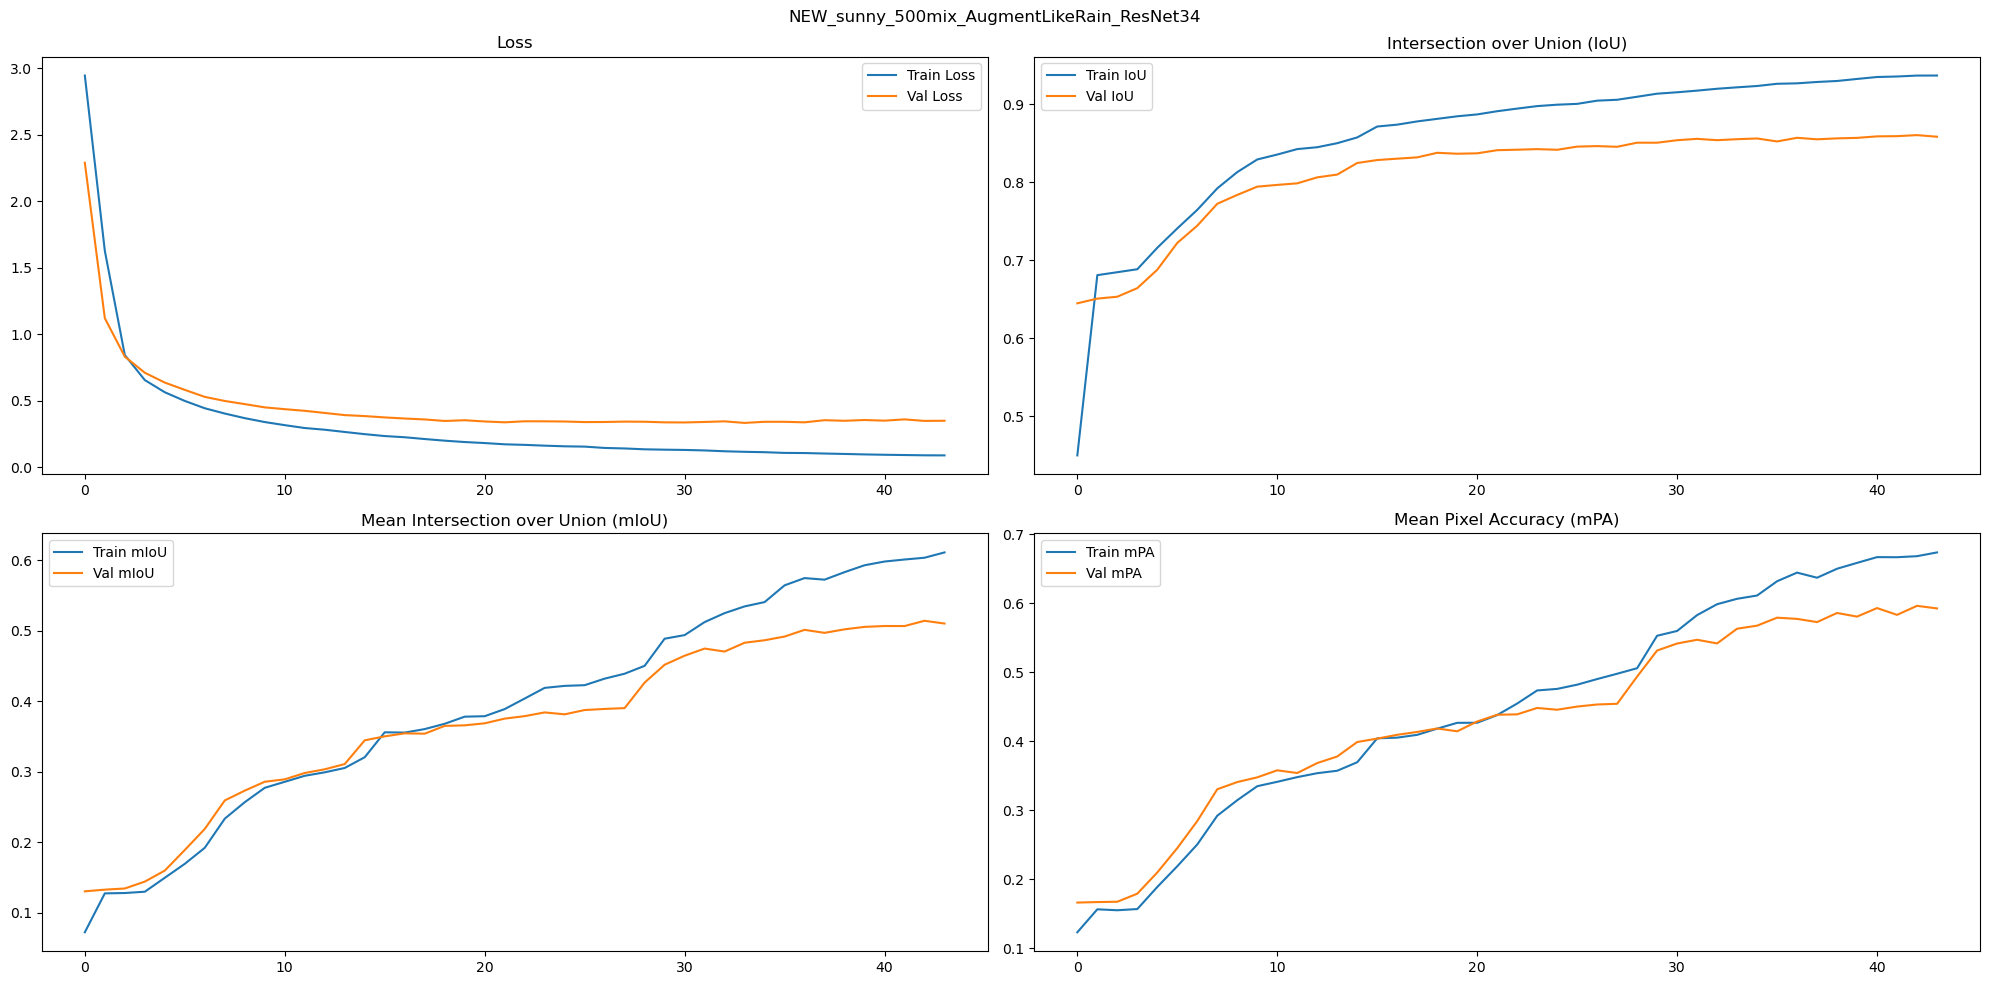

In [14]:
plot_results(history, runName)

In [15]:
import pickle 
# We save the history in case we would want to plot the results later
with open(runName + '_graphs.pkl', 'wb') as f:
    pickle.dump(history, f)

Prediction

In [16]:
import torch.nn.functional as F

def make_predictions(test_dataloader, best_model_path, device='cuda'):
    checkpoint = torch.load(best_model_path)
    
    model = UnetResnet34(output_classes=30)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    pred_masks = []
    with torch.no_grad():
        for images, _ in test_dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)
            pred_masks.append(preds.cpu())
    
    return torch.cat(pred_masks, dim=0)

In [17]:
modelPath = '/net/cremi/mhajnal/espaces/travail/am4ipProject/DONE/checkpoints/' + runName + '.pth'
predictions = make_predictions(test_loader, modelPath)

/tmp/cache-mhajnal/ipykernel_2608979/399524829.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)
/autofs/unityaccount/ens/DeepLear

Prepareing to show test metrics and visualize predictions

In [18]:
testMasks = []

for img,mask in test_loader:
    testMasks.append(mask)

testMasks = torch.cat(testMasks)

In [19]:
testIoU = calcIoU(predictions, testMasks, 30)
testmIoU = calcMeanIoU(predictions, testMasks, 30)
testmPA = calcMeanPA(predictions, testMasks, 30)

print(f"Test IoU: {testIoU:.4f}")
print(f"Test mIoU: {testmIoU:.4f}")
print(f"Test mPA: {testmPA:.4f}")

Test IoU: 0.8579
Test mIoU: 0.3906
Test mPA: 0.4661


Visuals

In [20]:
total_mask_output = []

for i,mask_pred in enumerate(predictions):
    height,width = mask_pred.shape
    
    mask_original = testMasks[i]
    ignore = mask_original == -1 # id: -1
    
    mask_predicted = torch.where(ignore, -1, mask_pred)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_output.append(mask_zeros)

In [21]:
total_mask_test = []

for mask_tst in testMasks:
    height,width = mask_tst.shape
    
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_test.append(mask_zeros)

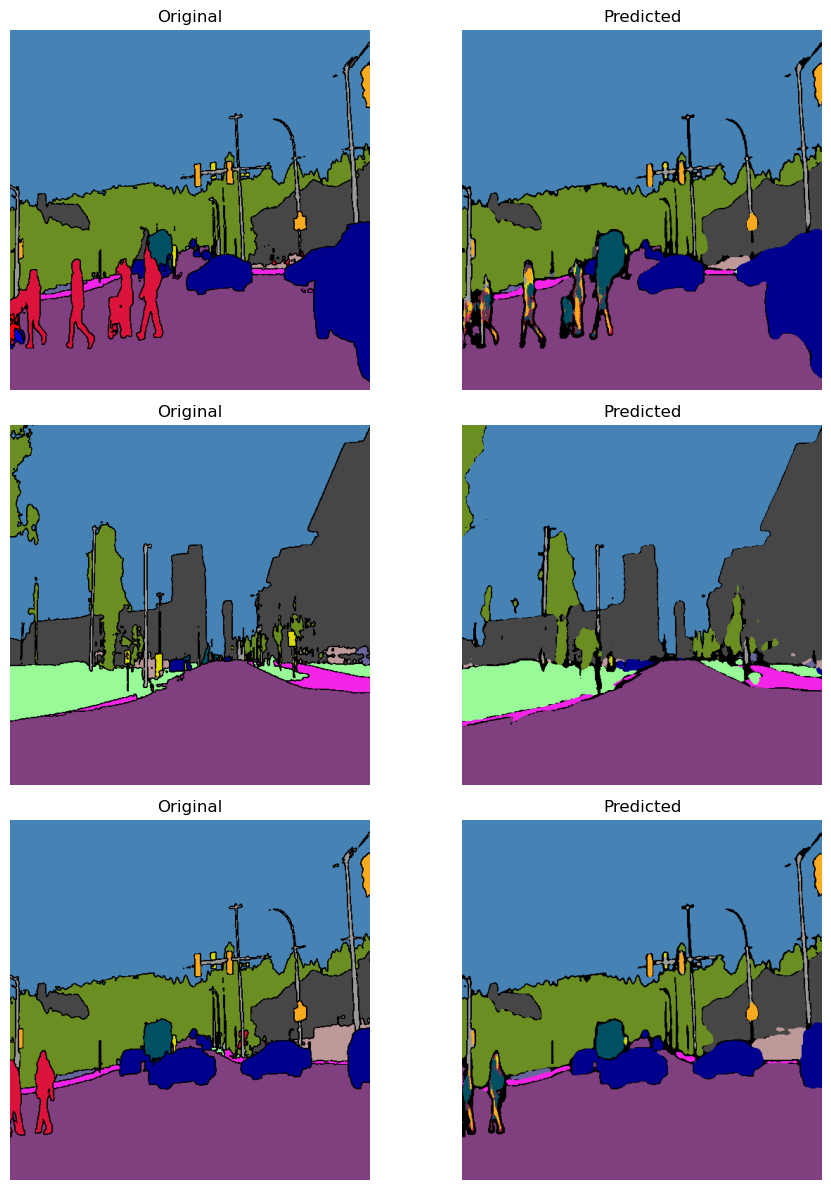

In [22]:
import matplotlib.pyplot as plt
import random

rand_1 = random.randint(1, len(total_mask_test))
rand_2 = random.randint(1, len(total_mask_test))
rand_3 = random.randint(1, len(total_mask_test))


images = [
    total_mask_test[rand_1].numpy(),
    total_mask_output[rand_1].numpy(),
    total_mask_test[rand_2].numpy(),
    total_mask_output[rand_2].numpy(),
    total_mask_test[rand_3].numpy(),
    total_mask_output[rand_3].numpy()
]

titles = [
    "Original",
    "Predicted",
    "Original",
    "Predicted",
    "Original",
    "Predicted"
]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

# Flatten the axes array for easy indexing
axes = axes.ravel()

# Plot each image in a separate subplot
for i, ax in enumerate(axes):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    else:
        # If you don't have enough images, you can hide extra subplots
        ax.axis('off')

plt.tight_layout()
plt.show()